# Oxford IIIT Pets Segmentation using PyTorch

In this notebook, we shall see how to create a SegNet-Basic model to perform image segmentation on the Oxford IIIT Pets dataset.
This dataset can be found [here](https://www.robots.ox.ac.uk/~vgg/data/pets/).

First, we'll create a SegNet Basic model with ~15.27M parameters and record the model's accuracy using multiple metrics:
1. Pixel Accuracy
2. IoU (using torchmetrics)
3. A custom IoU metric we define that is differentiable so that it can be used as a loss function if needed.

Then, we'll use Depthwise Separable Convolutions to reduce the number of parameters in this model from ~15.27M to ~1.75M and record the accuracy of this model on the test dataset using the same set of metrics as above.

Both models are trained for **20 epochs** on the same training dataset. We use random horizontal image flips and color jitter as data augmentation for the training dataset when training both models.

We see that using the depthwise separable convolutions reduces the number of model parameters by about 88% with a very small overall loss in pixel classification accuracy (i.e. the pixel classification accuracy goes from 88.39% to 87.31%).

Here are the detailed results.

| Model | Parameters (in millions) | Pixel Accuracy % | IoU Accuracy % | Custom IoU Accuracy % |
| -------- | ------- | -------- | ------- | -------- |
| SegNet-Basic With Standard Convolutions            | 15.27M | 88.39% | 72.91% | 59.93% |
| SegNet-Basic With Depthwise Separable Convolutions | 1.75M  | 87.31% | 70.49% | 63.04% |


### Imports and helper functions

In [3]:
CUDA_LAUNCH_BLOCKING=1

In [4]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
from pathlib import Path
working_dir = Path(os.getcwd())

In [5]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


# Fetch the Oxford IIIT Pets dataset (via Torchvision)

In [6]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision. -> SIMPLY loadinf the dataset. if error appears not finding the dataset, just update torchvision
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

In [7]:
pets_train_orig, pets_test_orig

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: /home/helldiver/repositories/learn_anything/ComputerVision/OxfordPets/train,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: /home/helldiver/repositories/learn_anything/ComputerVision/OxfordPets/test)

In [8]:
(train_pets_input, train_pets_target) = pets_train_orig[0]

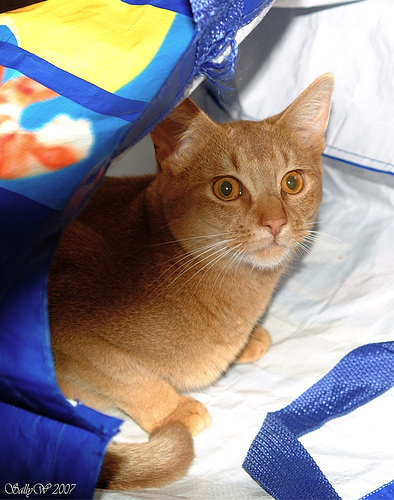

In [9]:
# Spot check an input image.
train_pets_input

# Trimap Legend for the mask


A trimap legend, in the context of image processing, particularly in the field of computer vision and image segmentation, is a graphical representation or annotation that indicates the different regions or classes within an image. ( Just look below )

In the case of trimaps, which are used in the context of image matting or foreground/background segmentation, the trimap legend typically represents three different regions:

1. <span style='color:green'> Foreground </span>: This region typically represents the area of the image that corresponds to the foreground object that you want to extract or segment from the background.

2. <span style='color:green'> Background </span>: This region represents the area of the image that corresponds to the background against which the foreground object is placed.

3. <span style='color:green'> Unknown or Transition </span>: This region represents the ambiguous or transition areas where it is not clear whether a pixel belongs to the foreground or background. These areas are often marked as uncertain, and the goal of the segmentation algorithm is to classify these pixels accurately.

<div style="font-size: 20px;">
After subtracting 1 from pixel value.

* 0 = Pet pixel (segmentation target) <span style='color:red'> FOREGORUND </span>
* 1 = background pixel   <span style='color:red'> BACKGORUND </span>
* 2 = border (ambiguous) region pixel    <span style='color:red'> UNKNOWN / TRANSITION </span>
</div>

In [10]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0 # White
    BACKGROUND = 1  # Grey
    BORDER = 2  # Black

In [11]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed using the range of colors -> [0, 256]
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

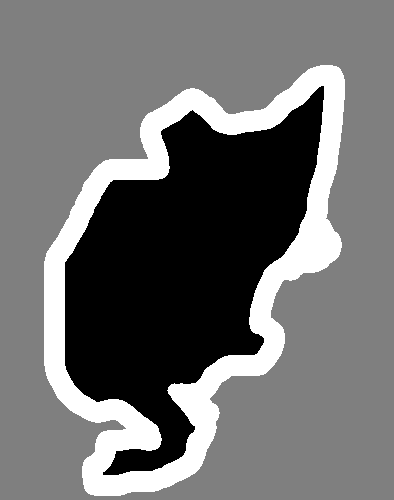

In [12]:
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
t2img(trimap2f(train_pets_target))

In [13]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
# Torch needs to be precise intructions when you send the CPU OR GPU
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"


# Dataset Wrappper and DataSet Loader

A dataset Wrappper in necessary for every new dataset since it is unique and has to be implemented case by case. Why not standardize something like this i have no idea

Every Dataset Wrapper usually needs to have a a 

* __def__ element 
* __len__ method which retruns the length of the dataset
* __getitem__ method: which returns the item of the dataset one by one. Here is where usually augmentations are applied using torch transform or albumentations

In [14]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.

class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform



    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

## Basic Segmentation

A basic segmentation mask is modelled also after the Trimap. For masks with more classes, the standard is to apply for each single pixel a value [0,n] where n is the total amount of classes in the dataset. 

Note that when you traina neural network, you provided both the input and the out: 
* Input: $ \begin{bmatrix} \\ (C)hannels, (H)eight, Width(W) \\ \end{bmatrix} $ corresponding to the .JPG image -> C = 3, for the RGB colors
* Output:  $ \begin{bmatrix} \\ (C)hannels, (H)eight, Width(W) \\ \end{bmatrix} $ correpsonginf to the .PNG Image -> the mask with C = 1, since there are only the values of the masks

THen the training try to reduce the loss function between these elements as much as possible

In [15]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]  -> in this format is impossible to visualize, but maybe to train yes
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=32,
    shuffle=True,
)

pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128]))

## Spot check input images and segmentation masks

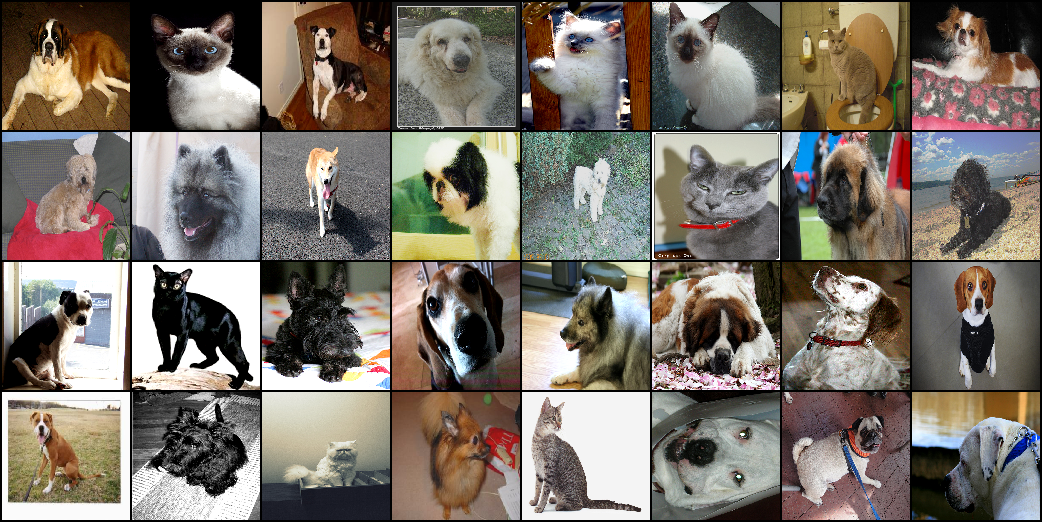

In [16]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

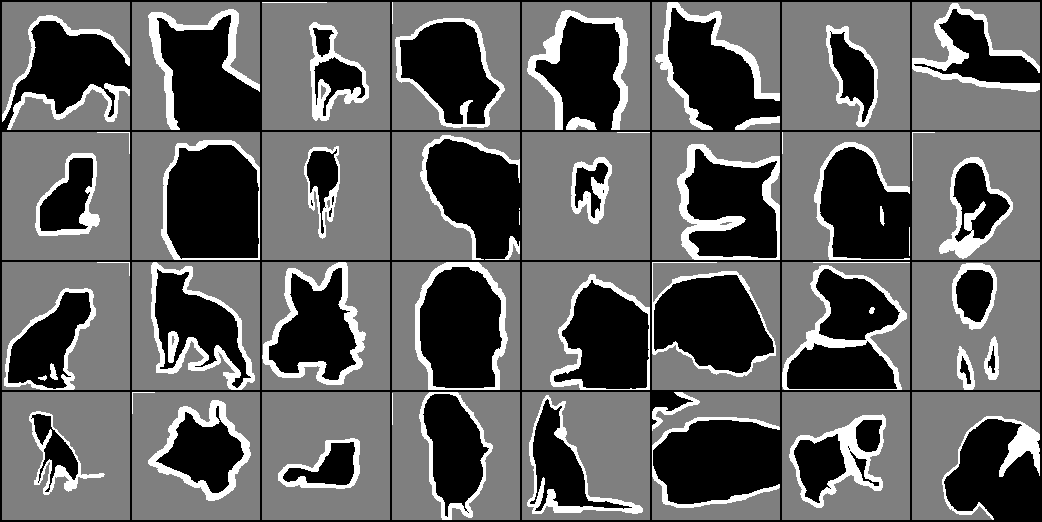

In [17]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

In [18]:
#                  N  C  H
# The printed row is the W dimension.
train_pets_targets[3][0][4]

tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

# SegNet Basic with standard convolutions

## Model definition (SegNet Basic)

We use a SegNet model architecture, since it's well suited for image segmentation tasks, and isn't as memory intensive as U-Net models are. More information about the SegNet model and its architecture can be found here: https://arxiv.org/abs/1511.00561

<img src='https://user-images.githubusercontent.com/27678705/33705132-74380e72-db72-11e7-8931-33dfd6d3ff0c.png'>

We specifically use a SegNet-Basic type of model (i.e. not very deep) since our input images are just 128x128 in dimension.

Ok, the dimension of pictures is 128x128, and i have JPG pictures with 3 channels and PNG pictures wit 1 channel that is the mask, in this case a trimap mask. -> How does the Neural Network receive such data and process them ? 

SegNet is easier to understand since it is composed only of Convolutional Layers 


In [19]:
# Model definition. We use a SegNet-Basic model with some minor tweaks.
# Our input images are 128x128.

# DownConv2(nn.Module): -> by calling nn.Module I am inheriting all the attribuites and methods of the class nn.Module

class DownConv2(nn.Module):     
    def __init__(self, chin, chout, kernel_size):   # basic contructor
        super().__init__()   # super().__init__() calls the constructor of the parent class (nn.Module). 
        # This allows you to set up the necessary components inherited from nn.Module.

        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 3
        self.bn_input = nn.BatchNorm2d(3)   # he mean and standard-deviation are calculated per-dimension over the mini-batches and γ and β are learnable parameter vectors of size C (where C is the input size)
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)
        # self.dc5 = DownConv3(512, 512, kernel_size=kernel_size)
        
        # self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv2(64, 3, kernel_size=kernel_size)
        
    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # SegNet Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        # Our images are 128x128 in dimension. If we run 4 max pooling
        # operations, we are down to 128/16 = 8x8 activations. If we
        # do another down convolution, we'll be at 4x4 and at that point
        # in time, we may lose too much spatial information as a result
        # of the MaxPooling operation, so we stop at 4 down conv
        # operations.
        # x, mp5_indices, shape5 = self.dc5(x)

        # SegNet Decoder
        # x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)
        
        return x
    # end def
# end class

In [20]:
from torchsummary import summary


In [25]:
from torchsummary import summary
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
m = ImageSegmentation(kernel_size=3)
m.eval()
to_device(m)
print("Input Shape of the Image: {}".format(train_pets_inputs.shape))
output = m(to_device(train_pets_inputs)).shape
print("Output Shape of the Image: {}".format(output))
# why the output is 3 ?
summary(m, (3, 128, 128)) 

Input Shape of the Image: torch.Size([32, 3, 128, 128])
Output Shape of the Image: torch.Size([32, 3, 128, 128])


AttributeError: 'torch.Size' object has no attribute 'size'

## Loss function (Custom IoU and Custom IoU Loss)

We define a custom IoU metric that is differentiable so that it can be used as a loss functions if needed.

This IoU metric is different from the standard IoU metric that has a hard distinction between predicted classes by the model. In this custom IoU metric, we use the probability of the predicted class (after applying SoftMax) to determine the degree of overlap. In that sense, this isn't a pure IoU metric, but it does help us capture the essense of an IoU metric.

IoU is also sometimes called Jaccard Index or Jaccard similarity metric.


### Why use IoU instead of pixel accuracy?

For segmentation tasks, if you have input images where (say) just 10% of the image has the object you wish to cover with the object segmentation mask, and the rest of the image is supposed to be classified as background, then the pixel accuracy metric may not be the best metric to use.

Here's why. If the model were to predict every pixel as a background pixel, it would trivially achieve 90% accuracy for its prediction!

Hence, for cases where the object and background pixels are unbalanced, an IoU metric may be a better choice.

Here are some links to learn more about metrics for segmentation tasks:
1. https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
2. https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388
3. https://towardsdatascience.com/evaluating-image-segmentation-models-1e9bb89a001b


In [52]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if
    
    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())
    # end def
# end class

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z
# end def

test_custom_iou_loss()

tensor(1.5876, grad_fn=<NegBackward0>)

## Model Training

In [53]:
# Train the model for a single epoch
def train_model(model, loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)
    # end if

    running_loss = 0.0
    running_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)
        
        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        # end if
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
        running_samples += targets.size(0)
        running_loss += loss.item()
    # end for

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
# end def


## Helpers for validation of results on the test dataset

In [54]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)
    
    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()
    
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if
    
    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

In [55]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    
    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []
    
    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)
        
        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())
        
        del inputs
        del targets
        del predictions
    # end for
    
    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)
    
    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

Epoch: 00, Accuracy[Pixel: 0.2727, IoU: 0.5652, Custom IoU: 0.2000]


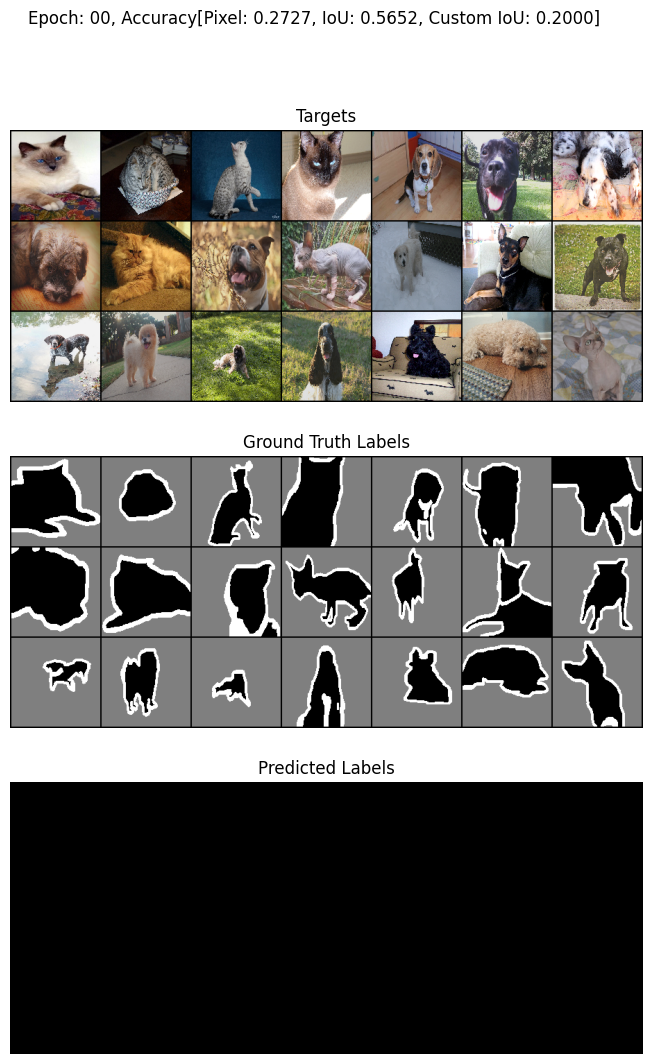

In [56]:
# Check if our helper functions work as expected and if the image
# is generated as expected.
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [57]:
# Optimizer and Learning Rate Scheduler.
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [58]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))
        # end with

        if scheduler is not None:
            scheduler.step()
        # end if
        print("")
    # end for
# end def

Epoch: 01, Learning Rate: 0.001


Trained 3680 samples, Loss: 0.8491
Epoch: 01, Accuracy[Pixel: 0.6875, IoU: 0.5073, Custom IoU: 0.3312]

Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7138
Epoch: 02, Accuracy[Pixel: 0.7427, IoU: 0.5570, Custom IoU: 0.3948]

Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6474
Epoch: 03, Accuracy[Pixel: 0.7629, IoU: 0.5964, Custom IoU: 0.4221]

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5894
Epoch: 04, Accuracy[Pixel: 0.7621, IoU: 0.6617, Custom IoU: 0.4567]

Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5473
Epoch: 05, Accuracy[Pixel: 0.7594, IoU: 0.6633, Custom IoU: 0.4506]

Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5096
Epoch: 06, Accuracy[Pixel: 0.8001, IoU: 0.6074, Custom IoU: 0.4793]

Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4791
Epoch: 07, Accuracy[Pixel: 0.8310, IoU: 0.6777, Custom IoU: 0.5553]

Epoch: 08, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.4467
Epoch: 08, A

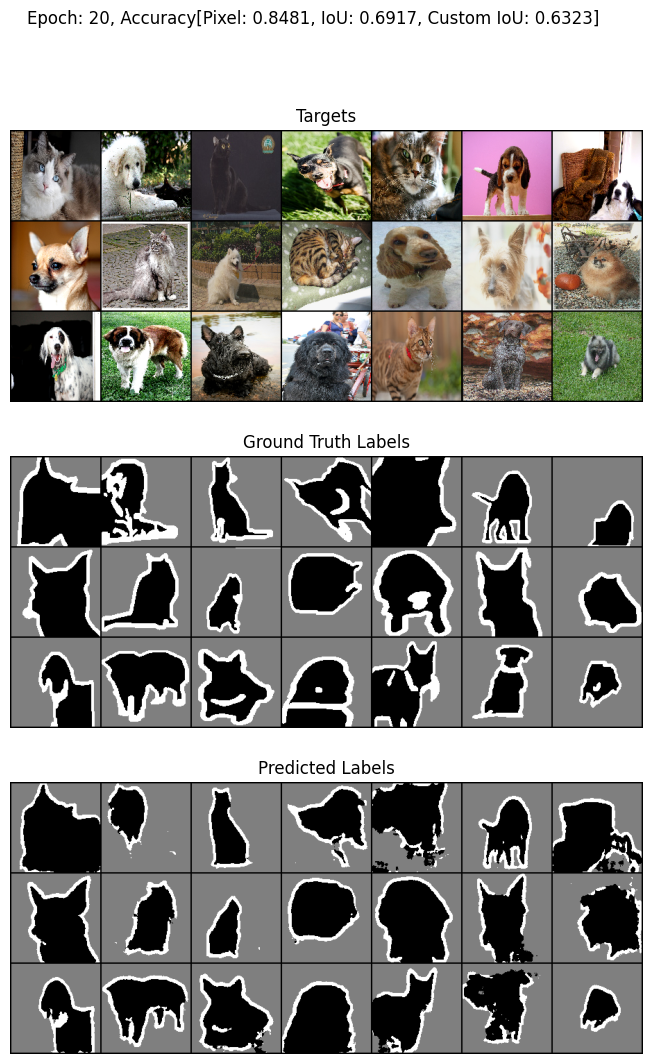

In [27]:
# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.
#
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 21), optimizer, scheduler, save_path)

In [59]:
# Save the model's checkpoint.
save_model_checkpoint(m, f"pets_segnet_CrossEntropyLoss_LRSchedule_20_epochs.pth")

## Model Size (15.27M parameters)

In [60]:
print_model_parameters(m)

The Model has 15.27M parameters


# SegNet Basic with depthwise-separable convolutions

We use depthwise separable convolutions to reduce the model's size (number of trainable parameters).

Depthwise Separable convolutions were first introduced by L. Sifre. Rigid-motion scattering for image classiﬁcation, 2014. in their Ph.D. thesis.

Depthwise separable convolutions were made popular by Mobilenet. You can read more about them here: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728


## Model Definition (SegNet Basic with depthwise separable convolutions)

In [61]:
# Model definition. We use a SegNet-Basic model with some minor tweaks.
# Our input images are 128x128.
# In this model, we use depth-wise-separable convolutions instead of
# "regular" convolutions.

class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        # The depthwise conv is basically just a grouped convolution in PyTorch with
        # the number of distinct groups being the same as the number of input (and output)
        # channels for that layer.
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, bias=bias, groups=in_channels)
        # The pointwise convolution stretches across all the output channels using
        # a 1x1 kernel.
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DownDSConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownDSConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpDSConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpDSConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            DepthwiseSeparableConv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)
        
    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentationDSC(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 3
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownDSConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownDSConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownDSConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownDSConv3(256, 512, kernel_size=kernel_size)
        # self.dc5 = DownConv3(512, 512, kernel_size=kernel_size)
        
        # self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpDSConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpDSConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpDSConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpDSConv2(64, 3, kernel_size=kernel_size)
        
    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # SegNet Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        # Our images are 128x128 in dimension. If we run 4 max pooling
        # operations, we are down to 128/16 = 8x8 activations. If we
        # do another down convolution, we'll be at 4x4 and at that point
        # in time, we may lose too much spatial information as a result
        # of the MaxPooling operation, so we stop at 4 down conv
        # operations.
        # x, mp5_indices, shape5 = self.dc5(x)

        # SegNet Decoder
        # x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)
        
        return x
    # end def
# end class

In [62]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
mdsc = ImageSegmentationDSC(kernel_size=3)
mdsc.eval()
to_device(mdsc)
mdsc(to_device(train_pets_inputs)).shape

torch.Size([32, 3, 128, 128])

## Model Size (1.75M parameters)

In [63]:
print_model_parameters(mdsc)

The Model has 1.75M parameters


Epoch: 00, Accuracy[Pixel: 0.2727, IoU: 0.5652, Custom IoU: 0.2000]


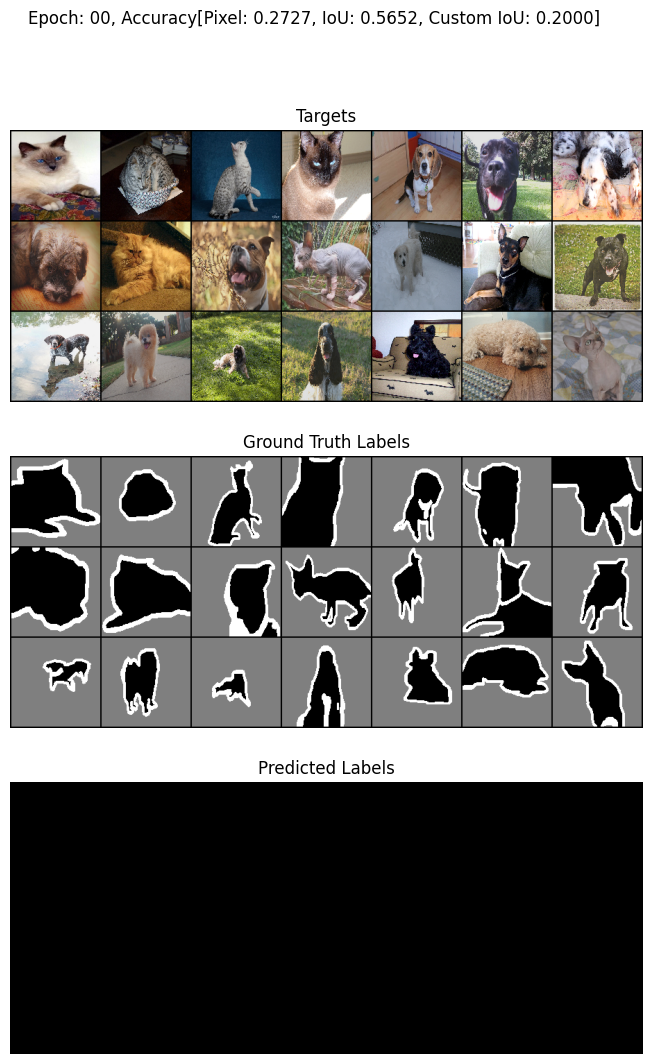

In [64]:
# Check if our helper functions work as expected and if the image
# is generated as expected.
save_path = os.path.join(working_dir, "segnet_basic_dsc_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(mdsc, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [65]:
to_device(mdsc)
optimizer2 = torch.optim.Adam(mdsc.parameters(), lr=0.001)
scheduler2 = None

## Model Training

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8828
Epoch: 01, Accuracy[Pixel: 0.7383, IoU: 0.4819, Custom IoU: 0.3534]

Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6993
Epoch: 02, Accuracy[Pixel: 0.7879, IoU: 0.6134, Custom IoU: 0.3929]

Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6329
Epoch: 03, Accuracy[Pixel: 0.7748, IoU: 0.6577, Custom IoU: 0.4292]

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5916
Epoch: 04, Accuracy[Pixel: 0.7800, IoU: 0.6692, Custom IoU: 0.4242]

Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5587
Epoch: 05, Accuracy[Pixel: 0.8164, IoU: 0.6714, Custom IoU: 0.4436]

Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5245
Epoch: 06, Accuracy[Pixel: 0.8146, IoU: 0.6771, Custom IoU: 0.4665]

Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5001
Epoch: 07, Accuracy[Pixel: 0.8285, IoU: 0.6675, Custom IoU: 0.4821]

Epoch: 08, Learning Rate: 0.001
Trained 3680 sam

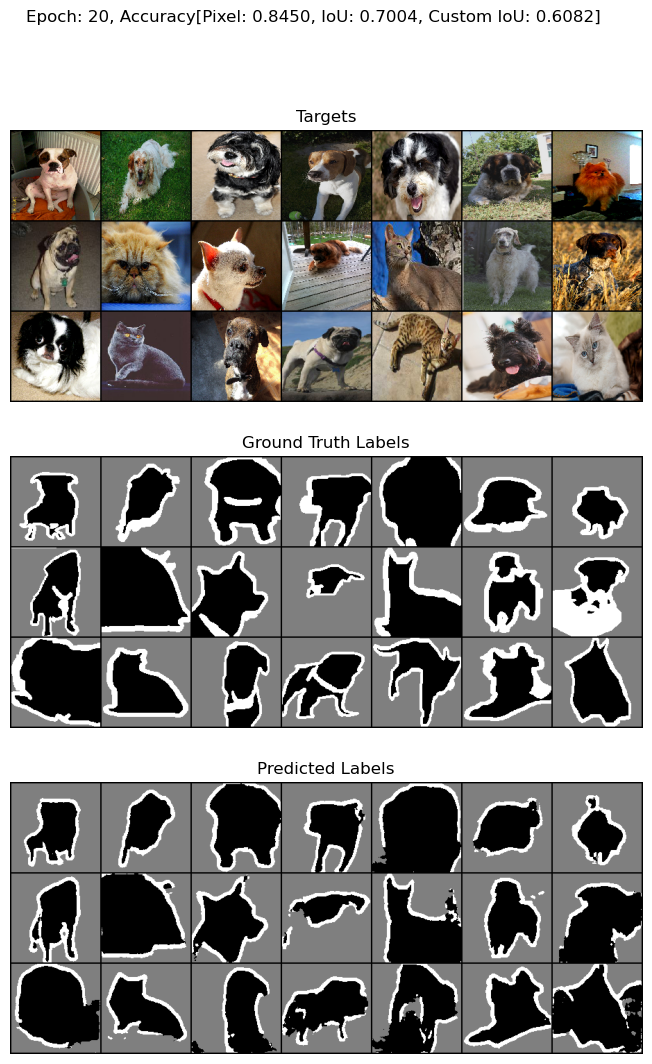

In [33]:
# Train the model that uses depthwise separable convolutions.
save_path2 = os.path.join(working_dir, "segnet_basic_dsc_training_progress_images")
train_loop(mdsc, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 21), optimizer2, scheduler2, save_path2)

In [66]:
save_model_checkpoint(mdsc, f"pets_segnet_DSC_CrossEntropyLoss_20_epochs.pth")

# Validate model accuracy on the complete test dataset

So far, we have been checking the metrics of interest only on a small subset of the test dataset (21 images).

Now, let's try to compute these numbers on the entire test dataset so that we can be sure that the numbers are representative.


In [67]:
# Load both model checkpoints.
load_model_from_checkpoint(m, f"pets_segnet_CrossEntropyLoss_LRSchedule_20_epochs.pth")
load_model_from_checkpoint(mdsc, f"pets_segnet_DSC_CrossEntropyLoss_20_epochs.pth")

<All keys matched successfully>

In [68]:
# Let's test the accuracy of both models on the test dataset.
with torch.inference_mode():
    # Accuracy of the model with ~15M parameters.
    test_dataset_accuracy(m, pets_test_loader)
    # Accuracy of the model with ~1.75M parameters.
    test_dataset_accuracy(mdsc, pets_test_loader)

The Model has 15.27M parameters


Test Dataset Accuracy
Pixel Accuracy: 0.3895, IoU Accuracy: 0.1455, Custom IoU Accuracy: 0.2000
The Model has 1.75M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.2802, IoU Accuracy: 0.3085, Custom IoU Accuracy: 0.2000


In [69]:
# Clear the PyTorch CUDA cache to free up some memory.
torch.cuda.empty_cache()

# GIF visualization

We package up all the images we generated at each training epoch so that we can visualize them as an animated GIF later.

In [70]:
# Zip up the images showing the progress of running segmentation
# on a small subset of the test dataset after every training epoch.
# This can be visualized using an animated gif.
!zip -r segnet_basic_training_progress_images.zip segnet_basic_training_progress_images 

zsh:1: command not found: zip


In [39]:
!zip -r segnet_basic_dsc_training_progress_images.zip segnet_basic_dsc_training_progress_images

  adding: segnet_basic_dsc_training_progress_images/ (stored 0%)
  adding: segnet_basic_dsc_training_progress_images/epoch_20.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_09.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_15.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_18.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_19.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_04.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_08.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_03.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_13.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_11.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_06.png (deflated 3%)
  adding: segnet_basic_dsc_training_progress_images/epoch_01.png (